In [1]:
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if (!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, httr,jsonlite,showtext)

#Signika font
font_add_google("Roboto", "rob")
showtext_auto()

Cargando paquete requerido: pacman



In [65]:
paleta_ipdp <- c("#9F2241","#BC955C",
                "#AC6D14","#799B48",
                 "#E02B75",
                 "#F08217",
                 "#f5aeb8",
                 "#de7aaf",
                 "black",
                 "#e5074c",
                 "#73cae6",
                 "#266cb4","#027A35")

In [2]:
##Hacer lista con urls de los archivos

presupuestos <- list(
  '2024' = 'https://datos.cdmx.gob.mx/dataset/3a6cba97-adb1-4f35-9df1-984cc3657aca/resource/7fa1da81-531c-477c-93db-7580bc1c7ad0/download/egresos_2024_aprobado.csv',
  '2023' = 'https://datos.cdmx.gob.mx/dataset/ea119a03-4f5a-46fa-afbe-bc32bcf79ec3/resource/5137e3db-227e-462d-8d59-1942afbc0c6a/download/egresos_2023_aprobado.csv',
  '2022' = 'https://datos.cdmx.gob.mx/dataset/755f47f1-b937-4131-8a7b-fbe306e747c8/resource/fc93c940-ad75-4e7f-afe6-c624726623a9/download/egresos_2022_aprobado.csv',
  '2021' = 'https://datos.cdmx.gob.mx/dataset/246be014-62ba-46e0-a7ce-9f37c8f01886/resource/682c37bd-96a2-4f78-94bf-3c77c3870f04/download/egresos_2021_aprobado.csv',
  '2020' = 'https://datos.cdmx.gob.mx/dataset/2bb4de63-8212-4d2a-a377-98b10f8384c6/resource/def0fc56-4e26-4cd2-9ec6-200cb86b418e/download/egresos_2020_aprobado.csv',
  '2019' = 'https://datos.cdmx.gob.mx/dataset/8dc52617-63f6-4bfd-9fae-54239675c6d0/resource/9a6f53d7-1751-4ae4-8bd8-d31807be7789/download/egresos_2019_aprobado.csv',
  '2018' = 'https://datos.cdmx.gob.mx/dataset/7a8820f2-3bea-4c69-8b20-1d01b1a99a6a/resource/5b20655c-072f-4347-baee-ab93d930b27b/download/egresos_2018_aprobado.csv'
)

In [3]:
presupuestos <- map_dfr(
  names(presupuestos),
  ~ read_csv(presupuestos[[.x]], show_col_types = FALSE) %>%
    mutate(year = as.numeric(.x))
) 

In [4]:
colnames(presupuestos)

[1] "clave_presupuestaria"                "ciclo"                              
 [3] "periodo"                             "gobierno_general"                   
 [5] "desc_gobierno_general"               "sector"                             
 [7] "desc_sector"                         "subsector"                          
 [9] "desc_subsector"                      "unidad_responsable"                 
[11] "desc_unidad_responsable"             "finalidad"                          
[13] "desc_finalidad"                      "funcion"                            
[15] "desc_funcion"                        "subfuncion"                         
[17] "desc_subfuncion"                     "area_funcional"                     
[19] "desc_area_funcional"                 "modalidad"                          
[21] "desc_modalidad"                      "programa_presupuestario"            
[23] "desc_programa_presupuestario"        "eje"                                
[25] "desc_eje"                            "objetivo_desarrollo_sostenible"     
[27] "desc_objetivo_desarrollo_sostenible" "tipo_recurso"                       
[29] "desc_tipo_recurso"                   "fuente_financiamiento"              
[31] "desc_fuente_financiamiento"          "fuente_generica"                    
[33] "desc_fuente_generica"                "fuente_especifica"                  
[35] "desc_fuente_especifica"              "ciclo_original"                     
[37] "origen_recurso"                      "desc_origen_recurso"                
[39] "fondo"                               "desc_fondo"                         
[41] "gasto_programable"                   "desc_gasto_programable"             
[43] "tipo_gasto"                          "desc_tipo_gasto"                    
[45] "capitulo"                            "desc_capitulo"                      
[47] "concepto"                            "desc_concepto"                      
[49] "partida_generica"                    "desc_partida_generica"              
[51] "partida_especifica"                  "desc_partida_especifica"            
[53] "consolidado"                         "desc_consolidado"                   
[55] "detalle_consolidado"                 "desc_detalle_consolidado"           
[57] "proyecto_inv"                        "desc_proy_inv"                      
[59] "tipo_proyecto"                       "desc_tipo_proyecto"                 
[61] "monto_aprobado"                      "monto_modificado"                   
[63] "monto_ejercido"                      "year"

In [6]:
presupuestos%>%
group_by(year)%>%
summarise(pecdmx=sum(monto_aprobado/1000000, na.rm=TRUE))%>%
#Calcular el crecimiento porcentual
mutate(var=pecdmx/lag(pecdmx)*100-100)

year,pecdmx,var
<dbl>,<dbl>,<dbl>
2018,226851.9,NA
2019,234016.3,3.158196
2020,238974.8,2.118855
2021,217962.2,-8.792825
2022,234005.9,7.360782
2023,248415.1,6.157626
2024,267965.4,7.870000


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
Warning message:
"ggrepel: 50 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


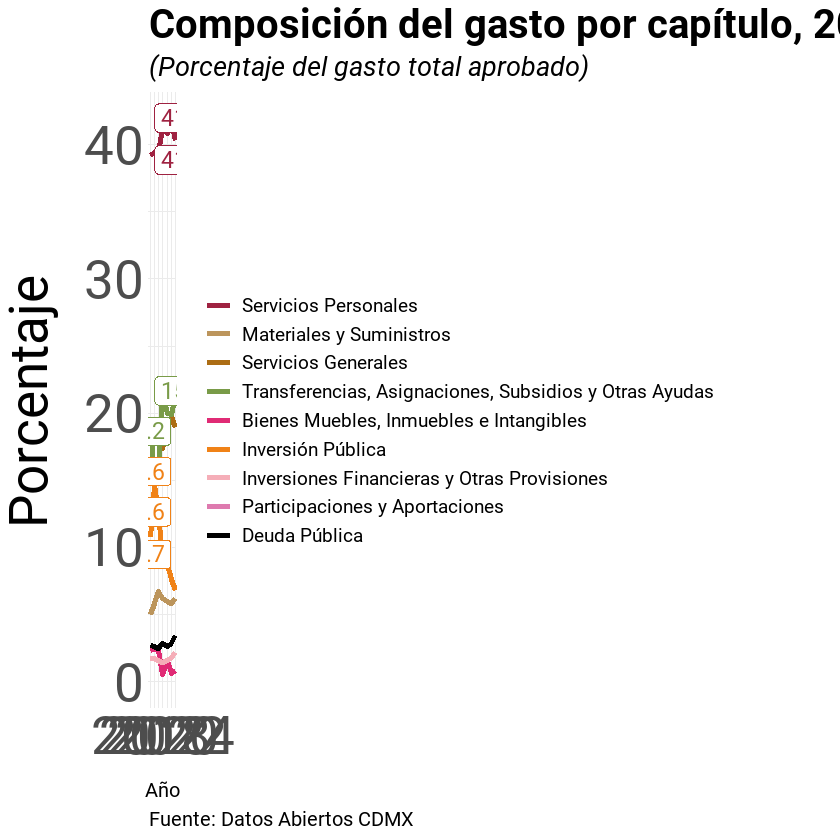

In [83]:
#Prespuesto por capítulo y año
presupuestos %>%
group_by(year, capitulo) %>%
summarise(pecdmx = sum(monto_aprobado/1000000, na.rm = TRUE)) %>%
mutate(pct= pecdmx / sum(pecdmx) * 100,
pct = round(pct, 1)) %>%
ungroup() %>%
select(year, capitulo, pct) %>%
mutate(capitulo=as.character(capitulo),
capitulo=case_when(
  capitulo == "1000" ~ "Servicios Personales",
  capitulo == "2000" ~ "Materiales y Suministros",
  capitulo == "3000" ~ "Servicios Generales",
  capitulo == "4000" ~ "Transferencias, Asignaciones, Subsidios y Otras Ayudas",
  capitulo == "5000" ~ "Bienes Muebles, Inmuebles e Intangibles",
  capitulo == "6000" ~ "Inversión Pública",
  capitulo == "7000" ~ "Inversiones Financieras y Otras Provisiones",
  capitulo == "8000" ~ "Participaciones y Aportaciones",
  capitulo == "9000" ~ "Deuda Pública",
  TRUE ~ capitulo),
  capitulo=fct_relevel(capitulo,
    "Servicios Personales", 
                    "Materiales y Suministros", 
                    "Servicios Generales", 
                    "Transferencias, Asignaciones, Subsidios y Otras Ayudas", 
                    "Bienes Muebles, Inmuebles e Intangibles", 
                    "Inversión Pública", 
                    "Inversiones Financieras y Otras Provisiones", 
                    "Participaciones y Aportaciones", 
                    "Deuda Pública"))%>%
ggplot(aes(x = year, y = pct, color = capitulo, group=capitulo)) +
  geom_line(size = 1.5) +
    ggrepel::geom_label_repel(aes(label = sprintf("%.1f", pct)), 
               size = 6, family = "rob", 
               show.legend = FALSE,
               nudge_y = 0.1, max.overlaps = 10)+
                 scale_color_manual("", values = paleta_ipdp) +
                theme_minimal() +
      labs(title = "Composición del gasto por capítulo, 2018-2024",
      subtitle=("(Porcentaje del gasto total aprobado)"),
      caption = "Fuente: Datos Abiertos CDMX",
      
       x = "Año", y = "Porcentaje") +
  theme_minimal() +
  theme(
    text = element_text(family = "rob"),
    legend.text = element_text(size = 14),
    legend.title = element_text(size = 20),
    plot.title = element_text(size = 30, hjust = 0, face = "bold"),
    plot.subtitle = element_text(size = 20,hjust = 0,face="italic"),
    plot.caption = element_text(size = 15, hjust = 0),
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 40),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 40),
    axis.text.y = element_text(size = 40),
    legend.position = "right"
  )

ggsave("part_cap_gasto.png", width = 12, height = 8, dpi = 200, bg = "white")
